In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

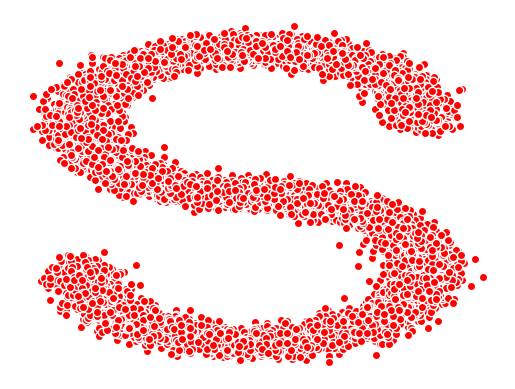

In [2]:
s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

data = s_curve.T # [2,10000]
fig,ax= plt.subplots()
ax.scatter(*data,c='r',edgecolors='w')
ax.axis('off')
plt.show()

dataset = torch.Tensor(s_curve).float()

## 确定超参数的值

In [4]:
num_steps = 100
betas = torch.linspace(-6,6,num_steps) 
betas = torch.sigmoid(betas)
betas = betas* (5e-3-1e-5)+1e-5 #将betas张量中的每个值缩放到一个范围，这个范围是从1e-5到5e-3。
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,dim=0) # 计算累乘Cumulative product
alphas_prod_p = torch.cat([torch.tensor([1.0]),alphas_prod[:-1]],0) # p = previous
alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alphas_bar_log = torch.log(1-alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape == (num_steps,)
print('all same shape:',betas.shape)

all same shape: torch.Size([100])


## 给定初始参数$x_0$和任意时刻$t$,计算$x_t$的采样值

计算公式
$$
x_t = \sqrt{\bar a_t}x_0 +\sqrt{1-\bar a_t}\epsilon

In [5]:
def q_x(x_0,t):
    """
    扩散过程,基于x0计算出任意时刻的采样x[t]
    """
    noise = torch.randn_like(x_0) # 生成与x0同形状的随机张量(服从正态分布)
    return alphas_bar_sqrt[t]*x_0 + one_minus_alphas_bar_sqrt[t]*noise,noise

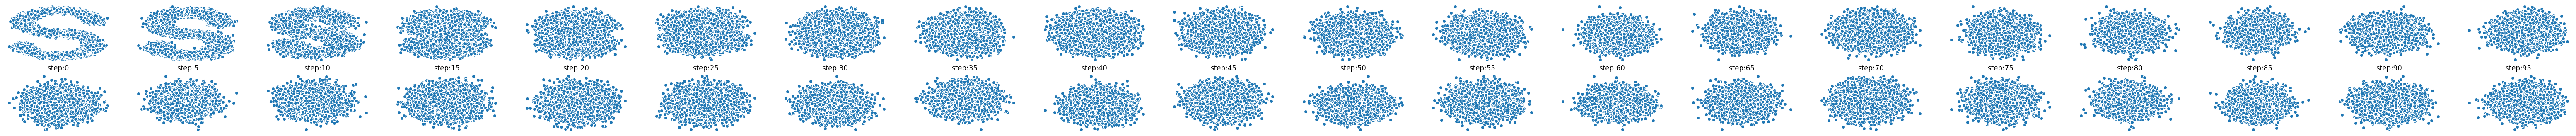

In [6]:
# 绘制示例图
num_show = 20
q_x(dataset,50)[1].shape
fig,axs = plt.subplots(2,num_show,figsize=(80,4))
plt.rc('text',color = 'b')

for i in range(num_show):
    x_0 = dataset
    x_t,noise = q_x(x_0,i*5)
    axs[0,i].scatter(*x_t.T, edgecolors='w')
    axs[0,i].axis('off')
    axs[1,i].scatter(*noise.T,edgecolors='w')
    axs[1,i].axis('off')
    axs[1,i].set_title('step:{}'.format(i*5))
# 保存svg图片
plt.savefig('q_x.svg',format='svg')

## 逆扩散过程

In [7]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128) -> None:
        super().__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units), # 输入2  一个是均值 一个是方差
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2)
            ]
        )
        
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
        
    
    def forward(self,x_0,t):
        x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        x = self.linears[-1](x)
        return x

## 误差函数
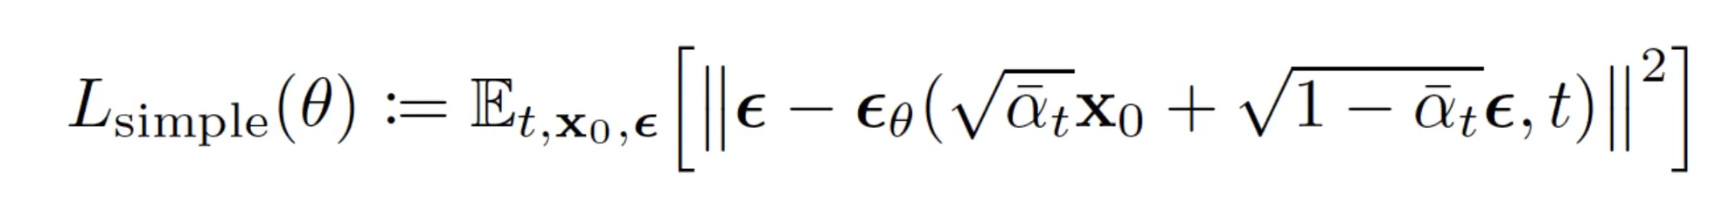

In [21]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻t进行采样计算"""
    
    batch_size = x_0.shape[0]
    
    # 对一个batchsize的样本生成随机的时刻t
    t = torch.randint(0,n_steps,size = (batch_size//2,)) # 先生成一个batchsize/2的随机数 
    y = n_steps-1-t
    t = torch.cat([t,y],dim=0) # 将t与n_steps-1-t拼接起来 目的是为了尽可能覆盖到更多的t shape= [batch_size]
    t = t.unsqueeze(-1) # shape = [batch_size,1] 升维操作
    t = t.to(device)
    
    a = alphas_bar_sqrt[t].to(device)
    am1 = one_minus_alphas_bar_sqrt[t].to(device)
    
    e = torch.randn_like(x_0).to(device) # 生成与x0同形状的随机张量(服从正态分布)
    x = x_0*a + e*am1 
    
    # x_0*a + e*am1 
    
    out = model(x,t.squeeze(-1))
    
    return (e-out).pow(2).mean()


## 逆扩散采样函数

In [9]:
def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])
    coeff = betas[t]/one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x,t)
    mean = (1/(1-betas[t]))*(x-coeff*eps_theta)
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    sample = mean+sigma_t*z
    return (sample)



def p_sample_loop(model,shape,num_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]中恢复x[T-1],x[T-2]...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(num_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    
    return x_seq

## 模型训练

In [22]:
import time
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text',color = 'blue')
model = MLPDiffusion(num_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epoch):
    start_time = time.time()
    for idx,batch in enumerate(dataloader):
        batch = batch.to(device)
        loss = diffusion_loss_fn(model,batch,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #?
        optimizer.step()
        end_time = time.time()
    print('epoch:{},loss:{},time:{}'.format(epoch,idx,loss.item(),end_time-start_time))

    if epoch%100 == 0:
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        fig , axs = plt.subplots(1,10,figsize=(40,4))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(*cur_x.T,edgecolors='w')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('step:{}'.format(i*10))
        

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

/Users/zane/miniforge3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


epoch:100/8000,loss:0.44730067253112793,0.061s/epoch
epoch:200/8000,loss:0.4514576494693756,0.058s/epoch
epoch:300/8000,loss:0.4382286071777344,0.064s/epoch
epoch:400/8000,loss:0.3848133981227875,0.058s/epoch
epoch:500/8000,loss:0.37778428196907043,0.062s/epoch


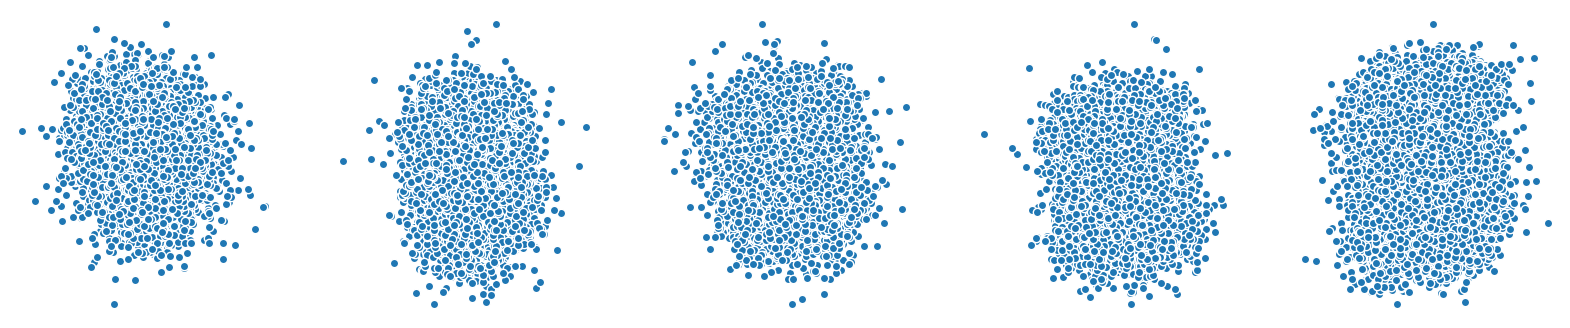

epoch:600/8000,loss:0.43698930740356445,0.069s/epoch
epoch:700/8000,loss:0.33827322721481323,0.056s/epoch
epoch:800/8000,loss:0.30620571970939636,0.065s/epoch
epoch:900/8000,loss:0.2698052227497101,0.056s/epoch
epoch:1000/8000,loss:0.3717363476753235,0.057s/epoch


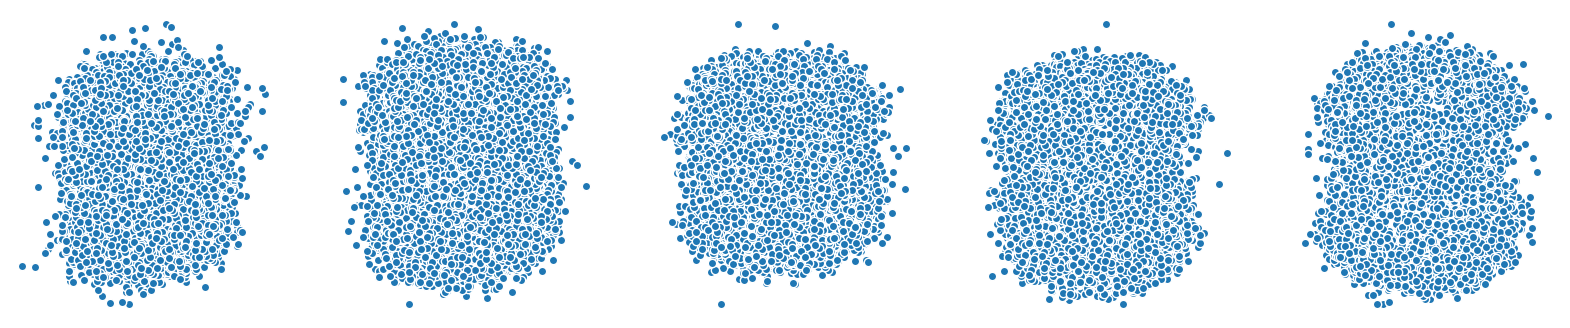

epoch:1100/8000,loss:0.3561326861381531,0.071s/epoch
epoch:1200/8000,loss:0.3572242856025696,0.059s/epoch
epoch:1300/8000,loss:0.37171441316604614,0.063s/epoch
epoch:1400/8000,loss:0.36071327328681946,0.066s/epoch
epoch:1500/8000,loss:0.3684293031692505,0.084s/epoch


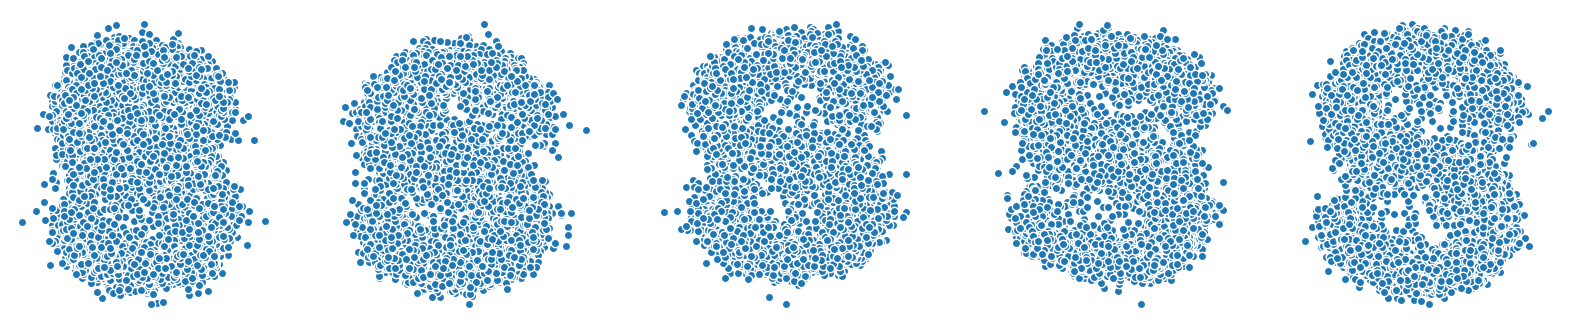

epoch:1600/8000,loss:0.38217538595199585,0.078s/epoch
epoch:1700/8000,loss:0.2955590486526489,0.068s/epoch
epoch:1800/8000,loss:0.39624863862991333,0.069s/epoch
epoch:1900/8000,loss:0.3507714569568634,0.068s/epoch
epoch:2000/8000,loss:0.31822940707206726,0.068s/epoch


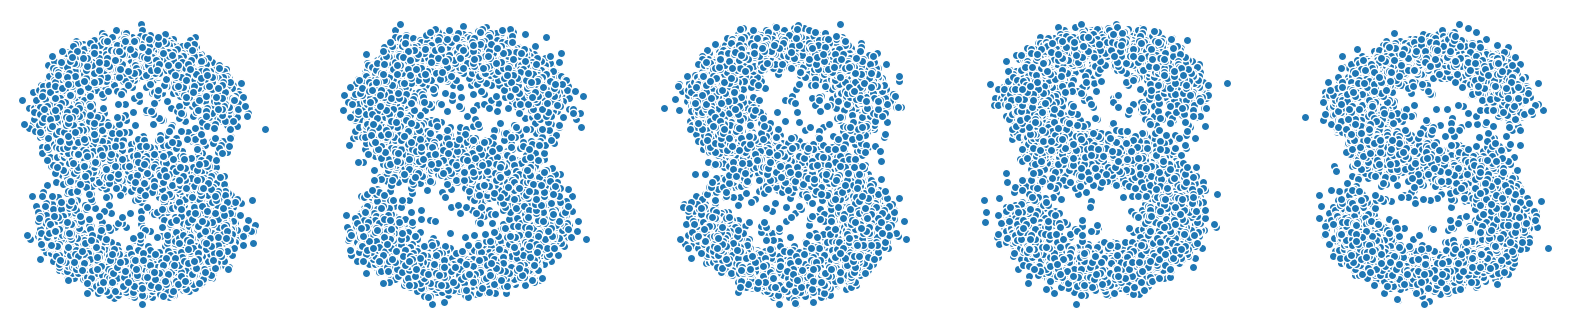

epoch:2100/8000,loss:0.2887742221355438,0.080s/epoch
epoch:2200/8000,loss:0.38288334012031555,0.068s/epoch
epoch:2300/8000,loss:0.36818927526474,0.068s/epoch
epoch:2400/8000,loss:0.38038936257362366,0.073s/epoch
epoch:2500/8000,loss:0.3364380896091461,0.077s/epoch


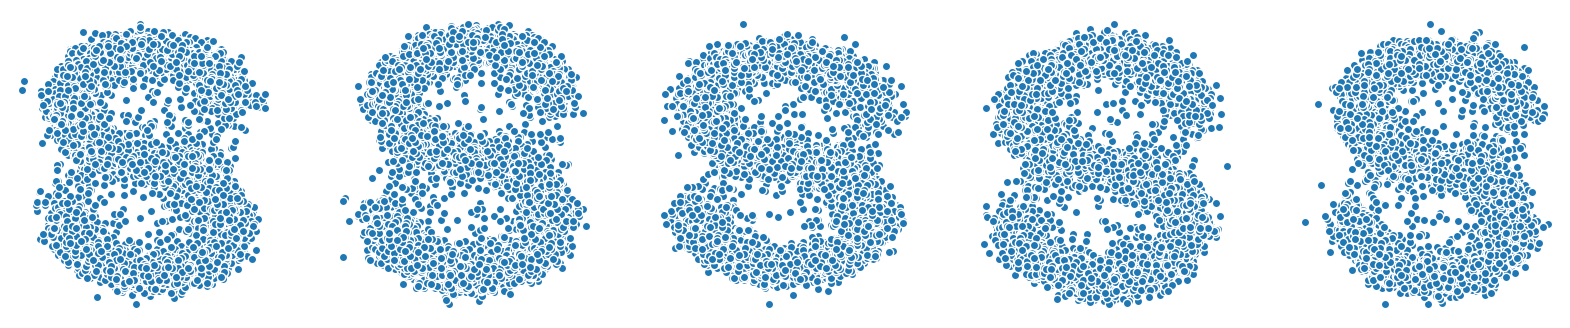

epoch:2600/8000,loss:0.31168437004089355,0.100s/epoch
epoch:2700/8000,loss:0.3577350378036499,0.074s/epoch
epoch:2800/8000,loss:0.3078102469444275,0.065s/epoch
epoch:2900/8000,loss:0.3092378079891205,0.067s/epoch
epoch:3000/8000,loss:0.37786224484443665,0.068s/epoch


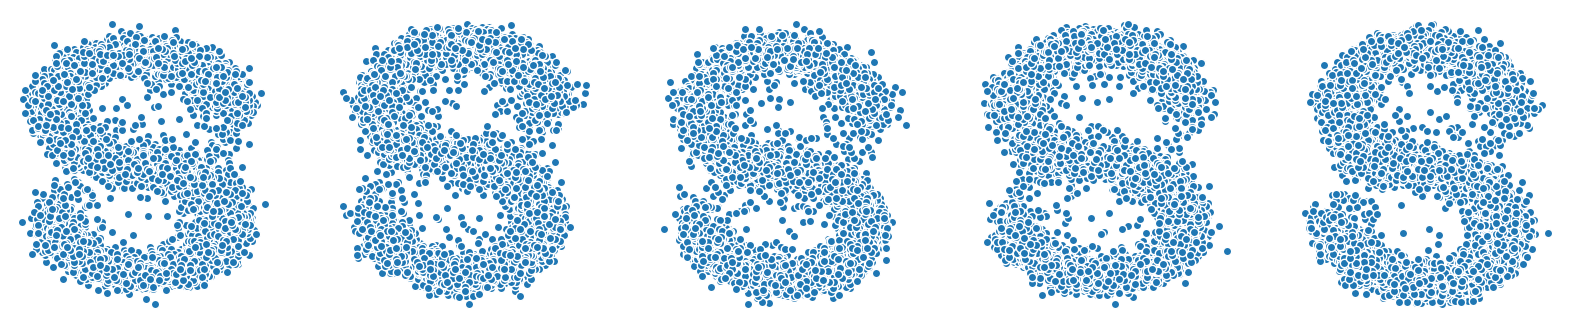

epoch:3100/8000,loss:0.29988494515419006,0.084s/epoch
epoch:3200/8000,loss:0.29069674015045166,0.071s/epoch
epoch:3300/8000,loss:0.384801983833313,0.065s/epoch
epoch:3400/8000,loss:0.33735114336013794,0.068s/epoch
epoch:3500/8000,loss:0.32654693722724915,0.085s/epoch


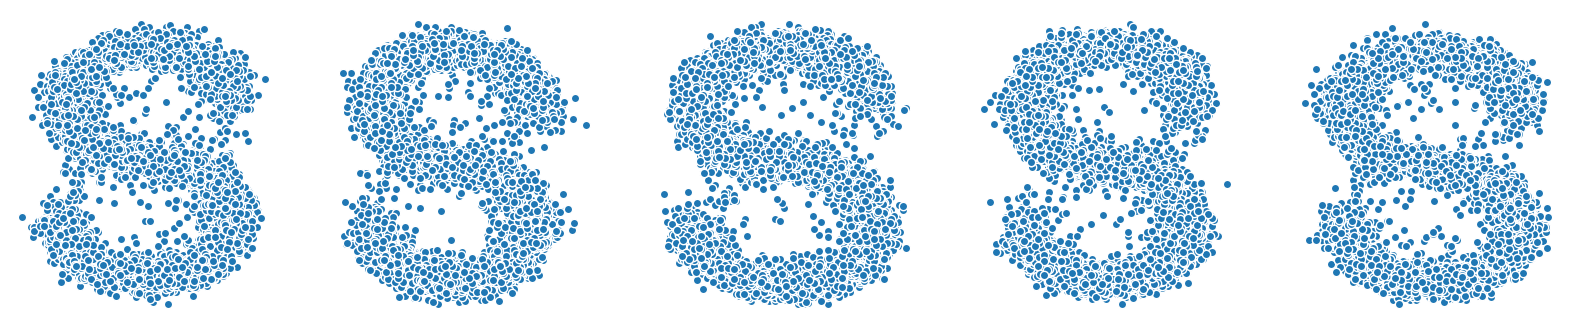

epoch:3600/8000,loss:0.3458626866340637,0.079s/epoch
epoch:3700/8000,loss:0.3420099914073944,0.067s/epoch
epoch:3800/8000,loss:0.3481270968914032,0.069s/epoch
epoch:3900/8000,loss:0.35114747285842896,0.068s/epoch


KeyboardInterrupt: 